<a href="https://colab.research.google.com/github/Snehlata1111/Google-Cloud-Data-Analysis--Employee-Retention-Program/blob/main/Analysis_Employee_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Big Query

In [ ]:
#libraries that we need
from google.cloud import bigquery
from google.colab import auth

#authenticate
auth.authenticate_user()

#initialize the client BigQuery
project_id = 'churn-cloud-project-469719'
client = bigquery.Client(project=project_id, location='US')



In [ ]:
#get dataset and table
dataset_ref = client.dataset('employeedata', project=project_id)
dataset = client.get_dataset(dataset_ref)
table_ref= dataset.table('tbl_hr_data')
table = client.get_table(table_ref)
table.schema

[SchemaField('satisfaction_level', 'FLOAT', 'NULLABLE', None, None, (), None),
 SchemaField('last_evaluation', 'FLOAT', 'NULLABLE', None, None, (), None),
 SchemaField('number_project', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('average_montly_hours', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('time_spend_company', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('Work_accident', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('Quit_the_Company', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('promotion_last_5years', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('Departments', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('salary', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('employee_id', 'INTEGER', 'NULLABLE', None, None, (), None)]

In [ ]:
new_table_ref= dataset.table('tbl_new_employees')
new_table = client.get_table(new_table_ref)
new_table.schema

[SchemaField('satisfaction_level', 'FLOAT', 'NULLABLE', None, None, (), None),
 SchemaField('last_evaluation', 'FLOAT', 'NULLABLE', None, None, (), None),
 SchemaField('number_project', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('average_montly_hours', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('time_spend_company', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('Work_accident', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('Quit_the_Company', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('promotion_last_5years', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('Departments', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('salary', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('employee_id', 'STRING', 'NULLABLE', None, None, (), None)]

In [ ]:
# convert to dataframe
df = client.list_rows(table=table).to_dataframe()
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,Quit_the_Company,promotion_last_5years,Departments,salary,employee_id
0,0.440795,0.731814,3,81,5,0,0,0,marketing,high,1798
1,0.501400,0.846829,5,83,1,0,0,0,product_mng,high,292
2,0.344085,0.769493,4,87,4,0,0,0,IT,high,742
3,0.642203,0.577236,7,89,4,0,0,0,product_mng,high,711
4,0.585680,0.427303,3,89,6,0,0,0,hr,high,1091


In [ ]:
# convert to dataframe
df2 = client.list_rows(table=new_table).to_dataframe()
df2.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,Quit_the_Company,promotion_last_5years,Departments,salary,employee_id
0,0.537849,0.122914,2,208,2,0,0,0,IT,high,NE15043
1,0.056211,0.322600,2,229,5,1,0,0,IT,low,NE15086
2,0.555186,0.555949,2,187,3,0,0,0,RandD,medium,NE15035
3,0.605273,0.713086,2,218,3,0,0,0,RandD,high,NE15069
4,0.043437,0.162372,2,175,3,0,0,0,RandD,high,NE15082


# Build Model

# # sklearn



In [ ]:
# =======================================
# 1) Imports & basic setup
# =======================================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

project_id = 'churn-cloud-project-469719'  # already used above


# Code and Train Model

In [ ]:
# =======================================
# 2) Define columns
# =======================================
target = "Quit_the_Company"
id_col = "employee_id"   # we try to ignore this if it exists

# Figure out columns
known_cats = ["salary", "Departments"]
all_obj_like = df.select_dtypes(include=["object", "category"]).columns.tolist()
categorical_features = sorted(list(set(all_obj_like).union(known_cats)))

# Ignore only if it’s present
ignore_features = [col for col in [id_col] if col in df.columns]

# Features/target split
X = df.drop(columns=[target] + ignore_features, errors="ignore")
y = df[target]

numeric_features = [c for c in X.columns if c not in categorical_features]
print("Categorical:", categorical_features)
print("Numeric:", numeric_features)
print("Ignored:", ignore_features)


Categorical: ['Departments', 'salary']
Numeric: ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'promotion_last_5years']
Ignored: ['employee_id']


In [ ]:
# =======================================
# 3) Preprocessor
# =======================================
# Scaling numeric (harmless for RF; useful if you swap in other models)
num_transform = StandardScaler()
cat_transform = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transform, numeric_features),
        ("cat", cat_transform, categorical_features),
    ],
    remainder="drop"
)


In [ ]:
# =======================================
# 4) Train/validation split
# =======================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=123
)



Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.95      0.95       294
         1.0       0.87      0.88      0.87       106

    accuracy                           0.93       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.93      0.93      0.93       400


Confusion Matrix:
 [[280  14]
 [ 13  93]]

ROC-AUC: 0.9797041458092671


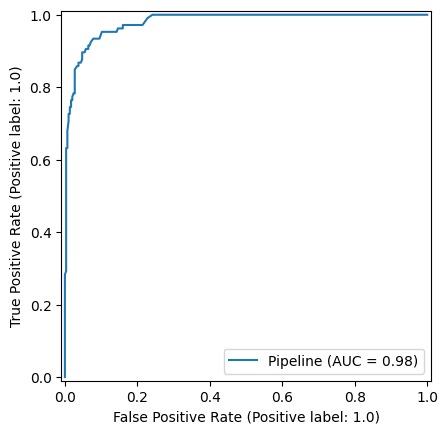

In [ ]:
# =======================================
# 5) Fix categorical features (drop id col)
# =======================================
categorical_features = [c for c in categorical_features if c not in ignore_features]

# Rebuild preprocessor with the corrected features
num_transform = StandardScaler()
cat_transform = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transform, numeric_features),
        ("cat", cat_transform, categorical_features),
    ],
    remainder="drop"
)

# =======================================
# 6) Pipeline with RandomForest
# =======================================
rf_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=123,
        class_weight="balanced"
    ))
])

# Fit model
rf_pipe.fit(X_train, y_train)

# Predict
y_pred = rf_pipe.predict(X_test)
y_prob = rf_pipe.predict_proba(X_test)[:, 1]

# =======================================
# 7) Evaluation
# =======================================
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nROC-AUC:", roc_auc_score(y_test, y_prob))

# Plot ROC curve
RocCurveDisplay.from_estimator(rf_pipe, X_test, y_test)
plt.show()


                         feature  importance
0        num__satisfaction_level    0.366295
3      num__average_montly_hours    0.212186
18               cat__salary_low    0.110579
1           num__last_evaluation    0.072596
19            cat__salary_medium    0.069790
4        num__time_spend_company    0.041690
2            num__number_project    0.032674
17              cat__salary_high    0.022201
7            cat__Departments_IT    0.007304
9    cat__Departments_accounting    0.007096
6     num__promotion_last_5years    0.007042
13  cat__Departments_product_mng    0.006662
12    cat__Departments_marketing    0.006056
11   cat__Departments_management    0.005876
10           cat__Departments_hr    0.005569


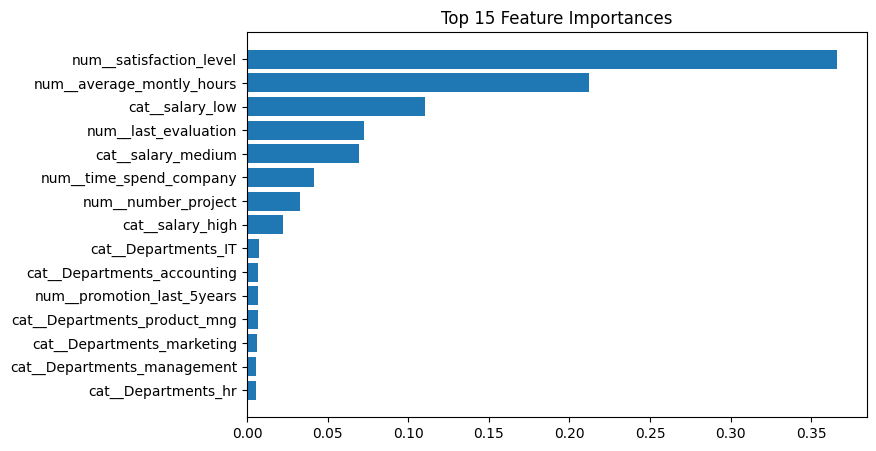

New employees shape: (100, 11)
   satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0            0.537849         0.122914               2                   208   
1            0.056211         0.322600               2                   229   
2            0.555186         0.555949               2                   187   
3            0.605273         0.713086               2                   218   
4            0.043437         0.162372               2                   175   

   time_spend_company  Work_accident  Quit_the_Company  promotion_last_5years  \
0                   2              0                 0                      0   
1                   5              1                 0                      0   
2                   3              0                 0                      0   
3                   3              0                 0                      0   
4                   3              0                 0                      0   

 

In [ ]:
# =======================================
# 6) Feature Importance
# =======================================
importances = rf_pipe.named_steps["model"].feature_importances_
feature_names = rf_pipe.named_steps["preprocessor"].get_feature_names_out()
feat_imp = pd.DataFrame({"feature": feature_names, "importance": importances})
feat_imp = feat_imp.sort_values("importance", ascending=False)
print(feat_imp.head(15))

plt.figure(figsize=(8,5))
plt.barh(feat_imp["feature"][:15], feat_imp["importance"][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances")
plt.show()


# =======================================
# Load NEW employees data (df2) again from BigQuery
# =======================================
query2 = f"SELECT * FROM `{project_id}.employeedata.tbl_new_employees`"
df2 = client.query(query2).to_dataframe()

print("New employees shape:", df2.shape)
print(df2.head())

# =======================================
# 7) Predictions on NEW Employees
# =======================================
X_new = df2.drop(columns=[id_col])   # drop employee_id
new_preds = rf_pipe.predict(X_new)
new_proba = rf_pipe.predict_proba(X_new)[:,1]

df2["Quit_Prediction"] = new_preds
df2["Quit_Probability"] = new_proba

print(df2.head())


# =======================================
# 8) Save Predictions back to BigQuery
# =======================================
from google.cloud import bigquery

# Define new table name
pred_table_id = f"{project_id}.employeedata.tbl_new_employees_predictions"

# Upload dataframe with predictions
job = client.load_table_from_dataframe(df2, pred_table_id)
job.result()  # Wait until finished

print(f"Predictions saved to {pred_table_id}")


In [ ]:
# =======================================
# 8) Save Predictions back to BigQuery
# =======================================
from google.cloud import bigquery

# Define new table name
pred_table_id = f"{project_id}.employeedata.tbl_new_employees_predictions"

# Upload dataframe with predictions
job = client.load_table_from_dataframe(df2, pred_table_id)
job.result()  # Wait until finished

print(f"Predictions saved to {pred_table_id}")

Predictions saved to churn-cloud-project-469719.employeedata.tbl_new_employees_predictions


In [ ]:
# =======================================
# 9) Create FEATURE TABLE
# =======================================

# Combine categorical + numeric features
all_features = numeric_features + categorical_features

# Create a feature table DataFrame
feature_table = pd.DataFrame({
    "Feature_Name": all_features,
    "Feature_Type": ["Numeric" if f in numeric_features else "Categorical" for f in all_features],
    "Description": ["TBD - Add description" for f in all_features]  # You can manually update later
})

print(feature_table)

# Save Feature Table to BigQuery
feature_table_id = f"{project_id}.employeedata.feature_table"

job = client.load_table_from_dataframe(feature_table, feature_table_id)
job.result()  # wait until done

print(f"Feature table saved to {feature_table_id}")


            Feature_Name Feature_Type            Description
0     satisfaction_level      Numeric  TBD - Add description
1        last_evaluation      Numeric  TBD - Add description
2         number_project      Numeric  TBD - Add description
3   average_montly_hours      Numeric  TBD - Add description
4     time_spend_company      Numeric  TBD - Add description
5          Work_accident      Numeric  TBD - Add description
6  promotion_last_5years      Numeric  TBD - Add description
7            Departments  Categorical  TBD - Add description
8                 salary  Categorical  TBD - Add description
Feature table saved to churn-cloud-project-469719.employeedata.feature_table


In [ ]:
print(y.value_counts(normalize=True))


Quit_the_Company
0    0.735
1    0.265
Name: proportion, dtype: Float64


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions on test set
y_pred = rf_pipe.predict(X_test)

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))


[[280  14]
 [ 13  93]]
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95       294
         1.0       0.87      0.88      0.87       106

    accuracy                           0.93       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.93      0.93      0.93       400



In [ ]:
X = X.copy()
X = X.astype({col: "float" for col in X.select_dtypes(include="Int64").columns})


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    rf_pipe,      # your pipeline
    X, y,         # full dataset
    cv=5,         # 5-fold cross-validation
    scoring="accuracy"
)


In [ ]:
print("Baseline CV Scores:", scores)
print("Mean Accuracy:", scores.mean())


Baseline CV Scores: [0.7425 0.84   0.795  0.945  0.8175]
Mean Accuracy: 0.828


In [ ]:
print(y.value_counts())
print(y.value_counts(normalize=True))


Quit_the_Company
0    1470
1     530
Name: count, dtype: Int64
Quit_the_Company
0    0.735
1    0.265
Name: proportion, dtype: Float64


In [ ]:
df.corr(numeric_only=True)[target].sort_values(ascending=False)


,Quit_the_Company
Quit_the_Company,1.000000
average_montly_hours,0.303633
Work_accident,0.045472
promotion_last_5years,0.038591
employee_id,0.018257
number_project,-0.004002
time_spend_company,-0.004453
last_evaluation,-0.012526
satisfaction_level,-0.481160


In [ ]:
for col in categorical_features:
    print(col, df.groupby(col)[target].mean())


Departments Departments
IT             0.238342
RandD          0.313131
accounting     0.283784
hr             0.282927
management     0.319797
marketing       0.21028
product_mng    0.226415
sales           0.19898
support         0.27027
technical      0.314607
Name: Quit_the_Company, dtype: Float64
salary salary
high      0.093458
low       0.434224
medium    0.091613
Name: Quit_the_Company, dtype: Float64
